In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

from scipy.stats import skew
from pathlib import Path

In [2]:
asthma_df = pd.read_csv("../data/raw/asthma_disease_data.csv")

In [3]:
PROJECT_ROOT = Path.cwd().parent

PROC_DIR = PROJECT_ROOT / "data" / "processed"

In [4]:
def camel_to_snake(name):
    # Insert underscore before capital letters, but keep abbreviations together
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)  
    s2 = re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1)  
    return s2.lower()

asthma_df.columns = [camel_to_snake(col) for col in asthma_df.columns]

In [5]:
asthma_df.columns = (
    asthma_df.columns
      .str.strip()
      .str.lower()
)

In [6]:
asthma_df.columns

Index(['patient_id', 'age', 'gender', 'ethnicity', 'education_level', 'bmi',
       'smoking', 'physical_activity', 'diet_quality', 'sleep_quality',
       'pollution_exposure', 'pollen_exposure', 'dust_exposure', 'pet_allergy',
       'family_history_asthma', 'history_of_allergies', 'eczema', 'hay_fever',
       'gastroesophageal_reflux', 'lung_function_fev1', 'lung_function_fvc',
       'wheezing', 'shortness_of_breath', 'chest_tightness', 'coughing',
       'nighttime_symptoms', 'exercise_induced', 'diagnosis',
       'doctor_in_charge'],
      dtype='object')

In [7]:
asthma_df["doctor_in_charge"].unique()

array(['Dr_Confid'], dtype=object)

The `doctor_in_charge` column has only one unique value (`"Dr_Confid"`).  
Since it contains no variance, it provides no useful information for modeling and was dropped from the dataset.

In [8]:
asthma_df = asthma_df.drop(columns=["doctor_in_charge"])

In [9]:
# Checking for missing values
asthma_df.isnull().sum()

patient_id                 0
age                        0
gender                     0
ethnicity                  0
education_level            0
bmi                        0
smoking                    0
physical_activity          0
diet_quality               0
sleep_quality              0
pollution_exposure         0
pollen_exposure            0
dust_exposure              0
pet_allergy                0
family_history_asthma      0
history_of_allergies       0
eczema                     0
hay_fever                  0
gastroesophageal_reflux    0
lung_function_fev1         0
lung_function_fvc          0
wheezing                   0
shortness_of_breath        0
chest_tightness            0
coughing                   0
nighttime_symptoms         0
exercise_induced           0
diagnosis                  0
dtype: int64

I checked the dataset for missing values before preprocessing and confirmed that the raw data had no NaNs.  

#### Outlier detection

Outliers can arise in clinical datasets either from true extreme cases (e.g. very low lung function in severe disease) or from errors in measurement/entry (e.g. implausible lung function >120%).  

For this reason, I applied a two-step rule to continuous variables:
- **IQR method** – to flag extreme statistical values.  
- **Medical plausibility thresholds** – to ensure flagged values are truly unrealistic, not just severe but valid patients.  

This hybrid approach avoids two common pitfalls:
- **Over-cleaning** (removing real patients with severe disease).  
- **Under-cleaning** (keeping values that are biologically impossible).  

I focused on **continuous variables** (Age, BMI, FEV1, FVC, FEV1/FVC ratio), because outliers are only meaningful when the data is numeric and continuous.  

The remaining features fall into categories where outlier detection is not applicable:
- **Binary variables** (e.g., gender, smoking, medical history, symptoms): already restricted to 0/1.  
- **Categorical variables** (e.g., ethnicity, education level, doctor in charge): values are discrete and predefined, so "outliers" don’t exist in the statistical sense.  
- **Lifestyle scores** (e.g., physical activity, diet, sleep, exposures): already bounded by design (0–10 scale).  

In [10]:
def detect_outliers(series, lower_bound=None, upper_bound=None):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    low_iqr = Q1 - 1.5 * IQR
    high_iqr = Q3 + 1.5 * IQR
    
    # Combine IQR with medical cutoffs
    low = max(low_iqr, lower_bound) if lower_bound is not None else low_iqr
    high = min(high_iqr, upper_bound) if upper_bound is not None else high_iqr
    
    outliers = series[(series < low) | (series > high)]
    return outliers, (low, high, Q1, Q3, IQR)

# --- Age ---
age_outliers = detect_outliers(asthma_df['age'], lower_bound=0, upper_bound=100)
print("Age outliers:", len(age_outliers))

# --- BMI ---
bmi_outliers = detect_outliers(asthma_df['bmi'], lower_bound=10, upper_bound=60)
print("BMI outliers:", len(bmi_outliers))

# FEV1
fev1_outliers, fev1_bounds = detect_outliers(asthma_df['lung_function_fev1'], lower_bound=0.5, upper_bound=6.0)
print("FEV1 outliers:", len(fev1_outliers))
print("Bounds used:", fev1_bounds)

# FVC
fvc_outliers, fvc_bounds = detect_outliers(asthma_df['lung_function_fvc'], lower_bound=1.5, upper_bound=7.0)
print("FVC outliers:", len(fvc_outliers))
print("Bounds used:", fvc_bounds)

Age outliers: 2
BMI outliers: 2
FEV1 outliers: 0
Bounds used: (0.5, 5.496072191388206, 1.8241134389318, 3.292896939914362, 1.4687835009825623)
FVC outliers: 0
Bounds used: (1.5, 7.0, 2.607488994768649, 4.86412078072103, 2.256631785952381)


**Age and BMI:**  There is a small number of outliers that I will check them manually. It is likely best to cap at realistic medical cutoffs (Age: 0–100, BMI: 10–60).

**FEV1 & FVC:** no cleaning needed. Distributions align well with expected physiology.

In [11]:
_, (low_age, high_age, q1_age, q3_age, iqr_age) = detect_outliers(asthma_df['age'], lower_bound=0, upper_bound=100)
print(f"Age min={asthma_df['age'].min()}, max={asthma_df['age'].max()}")
print(f"Age bounds: {low_age:.2f} – {high_age:.2f}")

# Recalculate BMI bounds and extremes
_, (low_bmi, high_bmi, q1_bmi, q3_bmi, iqr_bmi) = detect_outliers(asthma_df['bmi'], lower_bound=10, upper_bound=60)
print(f"BMI min={asthma_df['bmi'].min()}, max={asthma_df['bmi'].max()}")
print(f"BMI bounds: {low_bmi:.2f} – {high_bmi:.2f}")

Age min=5, max=79
Age bounds: 0.00 – 100.00
BMI min=15.031803385194396, max=39.985610652758176
BMI bounds: 10.00 – 52.44


Earlier “2 outliers” was triggered by the IQR-only calculation before we applied medical cutoffs. After checking actual values + medical plausibility → Age and BMI are clean, no capping needed.

##### FEV1/FVC Ratio Preprocessing

The FEV1/FVC ratio is normally expressed as a percentage. Physiologically plausible values are expected between **0–120%**, where values above 120% are considered implausible and most likely due to measurement or data entry errors.

In our dataset:
- About **16% of patients (≈375 cases)** had values >120%.
- These values cannot be interpreted as real physiology and need to be handled.

We considered three options:
1. **Clipping**: cap values at 120%.  
   - Advantage: keeps all rows in the dataset.  
   - Disadvantage: artificially reduces extreme outliers, but may introduce bias if many values are clipped.  

2. **Mark as NaN**: set values >120% to missing, then impute later.  
   - Advantage: more honest to the data, avoids introducing fake “120%” cases.  
   - Disadvantage: creates ~16% missingness, which will need careful imputation.  

3. **Raising the threshold** (e.g. 130%):  
   - Tested, but rejected. It only reduced outliers slightly while allowing physiologically impossible values.  

**Decision:**  
We adopt the **0–120% cutoff** and prepare **two parallel datasets**:
- **Dataset A (Clipped):** FEV1/FVC% capped at 120%.  
- **Dataset B (NaN):** FEV1/FVC% values >120% replaced with NaN.  

This dual approach allows us to later test the **robustness** of our models to preprocessing decisions.


In [12]:
asthma_df['fev1_fvc_pct_raw'] = asthma_df['lung_function_fev1'] / asthma_df['lung_function_fvc'] * 100
LOWER, UPPER = 0.0, 120.0
ratio_outliers, ratio_bounds = detect_outliers(asthma_df['fev1_fvc_pct_raw'], lower_bound= LOWER, upper_bound=UPPER)
print("Ratio outliers:", len(ratio_outliers))
print("Bounds used:", ratio_bounds)

Ratio outliers: 375
Bounds used: (0.0, 120.0, 47.04825946904091, 98.1559904878025, 51.10773101876159)


In [13]:
# Dataset A (clipped version)
asthma_clip = asthma_df.copy()
asthma_clip["fev1_fvc_pct"] = asthma_df["fev1_fvc_pct_raw"].clip(lower=LOWER, upper=UPPER)

# Dataset B (NaN version → treat >120% as missing)
asthma_nan = asthma_df.copy()
asthma_nan["fev1_fvc_pct"] = asthma_df["fev1_fvc_pct_raw"].mask(
    (asthma_df["fev1_fvc_pct_raw"] > UPPER) | (asthma_df["fev1_fvc_pct_raw"] < LOWER)
)

In [14]:
clip_path = PROC_DIR / "asthma_clip.parquet"
nan_path  = PROC_DIR / "asthma_nan.parquet"
asthma_clip.to_parquet(clip_path, index=False)
asthma_nan.to_parquet(nan_path, index=False)

#### Encoding

Not all categorical variables are equal — some have a natural order, while others do not.  
I will tailor the encoding strategy to match the data type:

- **Gender (0=Male, 1=Female)**  
  Already binary and numeric. I am keeping it as 0/1 because it is both interpretable and efficient.  
  One-hot encoding would create two redundant columns (`gender_0`, `gender_1`), which adds no value.

- **Education Level (0=None, 1=High School, 2=Bachelor’s, 3=Higher)**  
  This is an **ordinal variable**: the categories have a meaningful order (higher number = higher education).  
  Encoding it as ordinal preserves this progression. One-hot encoding would treat each level as unrelated, losing the information about educational progression.

- **Ethnicity (0=Caucasian, 1=African American, 2=Asian, 3=Other)**  
  This is a **nominal variable**: categories have no natural order.  
  Encoding as numbers (0,1,2,3) would incorrectly imply a ranking (e.g., “Asian > Caucasian”).  
  Therefore, we use **one-hot encoding**, creating one binary column per group. This preserves group identity without imposing artificial order.

This ensures all variables are machine-learning–ready while preserving their meaning.

In [15]:
asthma_data = asthma_clip.copy()

# Map ethnicity codes to names
ethnicity_map = {
    0: "caucasian",
    1: "african_american",
    2: "asian",
    3: "other"
}

# One-hot encode with meaningful names
ethnicity_dummies = pd.get_dummies(asthma_data["ethnicity"].map(ethnicity_map), prefix="ethnicity")

# Replace in dataframe
asthma_data = pd.concat([asthma_data.drop(columns=["ethnicity"]), ethnicity_dummies], axis=1)

print("Columns after encoding:", [c for c in asthma_data.columns if "ethnicity" in c])

Columns after encoding: ['ethnicity_african_american', 'ethnicity_asian', 'ethnicity_caucasian', 'ethnicity_other']


In [16]:
asthma_data.columns

Index(['patient_id', 'age', 'gender', 'education_level', 'bmi', 'smoking',
       'physical_activity', 'diet_quality', 'sleep_quality',
       'pollution_exposure', 'pollen_exposure', 'dust_exposure', 'pet_allergy',
       'family_history_asthma', 'history_of_allergies', 'eczema', 'hay_fever',
       'gastroesophageal_reflux', 'lung_function_fev1', 'lung_function_fvc',
       'wheezing', 'shortness_of_breath', 'chest_tightness', 'coughing',
       'nighttime_symptoms', 'exercise_induced', 'diagnosis',
       'fev1_fvc_pct_raw', 'fev1_fvc_pct', 'ethnicity_african_american',
       'ethnicity_asian', 'ethnicity_caucasian', 'ethnicity_other'],
      dtype='object')

In [17]:
target = asthma_data["diagnosis"]

In [18]:
pos = target.sum()
neg = len(target) - pos
print(f"Diagnosis positive rate: {pos}/{len(target)} = {pos/len(target):.2%}")

Diagnosis positive rate: 124/2392 = 5.18%


In [19]:
num_cols = [c for c in asthma_data.select_dtypes(include=[np.number]).columns 
            if c not in ["patient_id", "diagnosis"] and not c.startswith("ethnicity_")]

rows = []
for c in num_cols:
    corr = asthma_data[c].corr(asthma_data["diagnosis"])
    rows.append({"feature": c, "corr": corr, "abs_corr": abs(corr), "skew": skew(asthma_data[c].dropna())})

num_rank = pd.DataFrame(rows).sort_values("abs_corr", ascending=False)
num_rank.head(10)

,feature,corr,abs_corr,skew
24,exercise_induced,0.053956,0.053956,-0.429293
21,chest_tightness,-0.039278,0.039278,-0.013378
18,lung_function_fvc,0.029629,0.029629,-0.015271
19,wheezing,0.027197,0.027197,-0.391931
10,dust_exposure,-0.025972,0.025972,0.016457
22,coughing,-0.024193,0.024193,-0.013378
17,lung_function_fev1,0.023336,0.023336,-0.059109
16,gastroesophageal_reflux,0.022770,0.022770,1.875028
23,nighttime_symptoms,-0.021965,0.021965,-0.418576
4,smoking,-0.019321,0.019321,2.054549


Since the target diagnosis is binary, I measured point-biserial (Pearson) correlation between each numeric feature and the target.

WThis gives a quick sense of linear association — which numeric variables move together with the probability of diagnosis.

I excluded patient_id, and categorical one-hot columns, keeping only true numeric variables.

For each feature, I also computed skewness to check for highly imbalanced distributions.

Result:

No strong correlations were found. The top signals were:

exercise_induced (r ≈ 0.054)

chest_tightness (r ≈ -0.039)

lung_function_fvc (r ≈ 0.030)

All absolute correlations are <0.06 → meaning no single numeric feature strongly predicts diagnosis.

Some variables (e.g. gastroesophageal_reflux, smoking) are highly skewed, suggesting rare conditions that may still matter in modeling despite low correlation.

Overall, this confirms that diagnosis depends on a combination of features rather than one dominant predictor — so multivariate models (logistic regression, trees) will be more informative than univariate screening.

In [20]:
binary_cols = [
    "pet_allergy", "family_history_asthma", "history_of_allergies", "eczema", 
    "hay_fever", "gastroesophageal_reflux", "wheezing", "shortness_of_breath", 
    "chest_tightness", "coughing", "nighttime_symptoms", "exercise_induced"
]

results = []
for col in binary_cols:
    positive_rate = asthma_data.loc[asthma_data["diagnosis"] == 1, col].mean()
    negative_rate = asthma_data.loc[asthma_data["diagnosis"] == 0, col].mean()
    results.append({
        "feature": col,
        "positive_rate": positive_rate,
        "negative_rate": negative_rate,
        "difference": positive_rate - negative_rate
    })

bin_diff = pd.DataFrame(results).sort_values("difference", ascending=False)
bin_diff

,feature,positive_rate,negative_rate,difference
11,exercise_induced,0.717742,0.598765,0.118977
6,wheezing,0.653226,0.593034,0.060192
5,gastroesophageal_reflux,0.193548,0.156085,0.037464
1,family_history_asthma,0.298387,0.301146,-0.002759
2,history_of_allergies,0.395161,0.399471,-0.004310
3,eczema,0.177419,0.192681,-0.015261
0,pet_allergy,0.145161,0.167108,-0.021946
7,shortness_of_breath,0.467742,0.502205,-0.034463
4,hay_fever,0.217742,0.255291,-0.037549
10,nighttime_symptoms,0.556452,0.604938,-0.048487


I compared the prevalence of each binary medical history/symptom variable between patients with a positive asthma diagnosis and those without. For each feature I calculated the proportion of patients with the condition in both groups, and ranked them by the difference. This helps identify which symptoms or risk factors are more common in diagnosed patients.

The results show that exercise-induced symptoms stood out as the strongest signal: present in 72% of diagnosed patients vs 60% of non-diagnosed (+12%).

Wheezing was also more frequent in positives (65% vs 59%). Gastroesophageal reflux was slightly higher in positives (19% vs 16%), suggesting a modest link.

Other features (family history, allergies, eczema, pet allergy, hay fever) showed little to no difference, and in some cases were actually less common in diagnosed patients.

Interestingly, several symptoms you’d expect to be predictive — shortness of breath, chest tightness, coughing, nighttime symptoms — were actually less common in the diagnosed group. This could mean these symptoms are widespread in both groups or not specific enough to distinguish asthma.

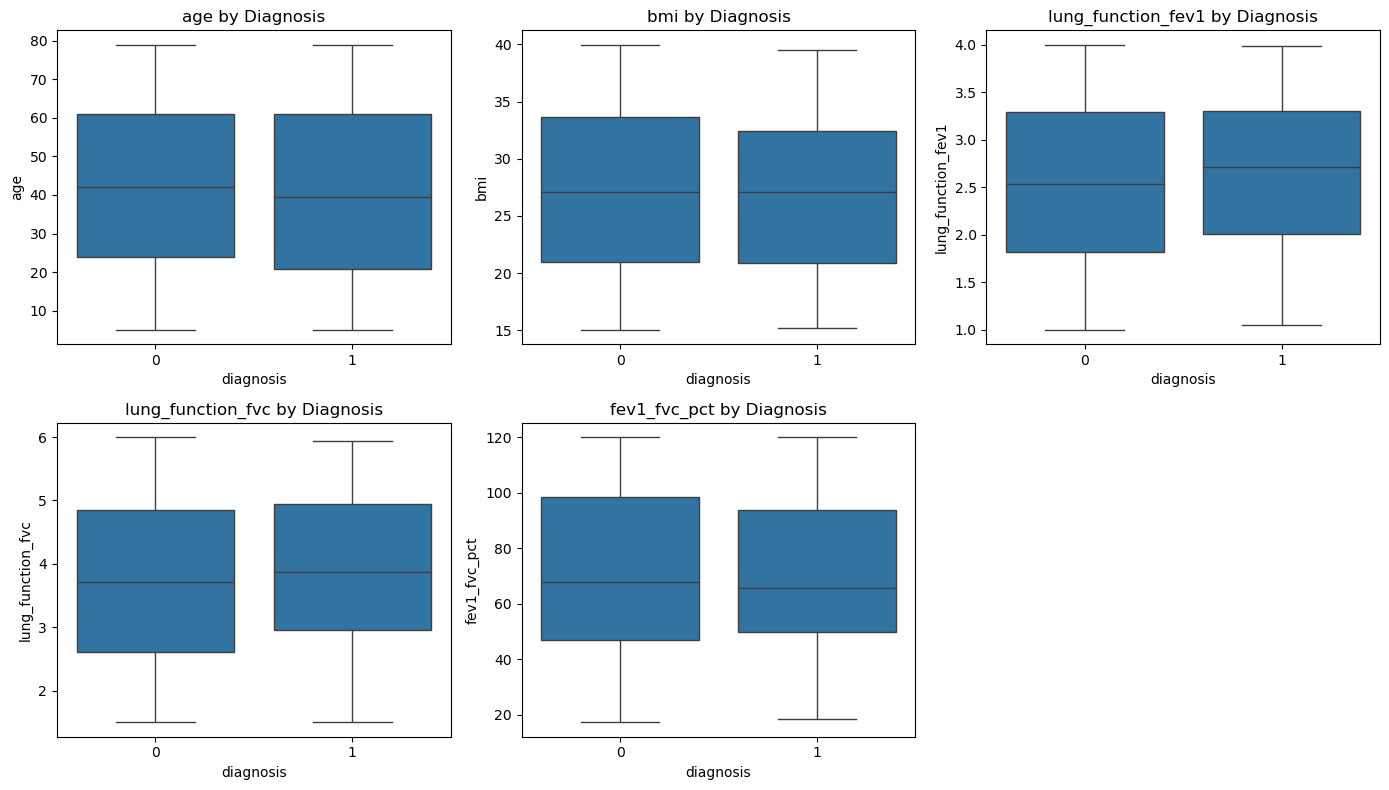

In [21]:
continuous = ["age", "bmi", "lung_function_fev1", "lung_function_fvc", "fev1_fvc_pct"]

plt.figure(figsize=(14, 8))
for i, col in enumerate(continuous, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x="diagnosis", y=col, data=asthma_data)
    plt.title(f"{col} by Diagnosis")
plt.tight_layout()
plt.show()

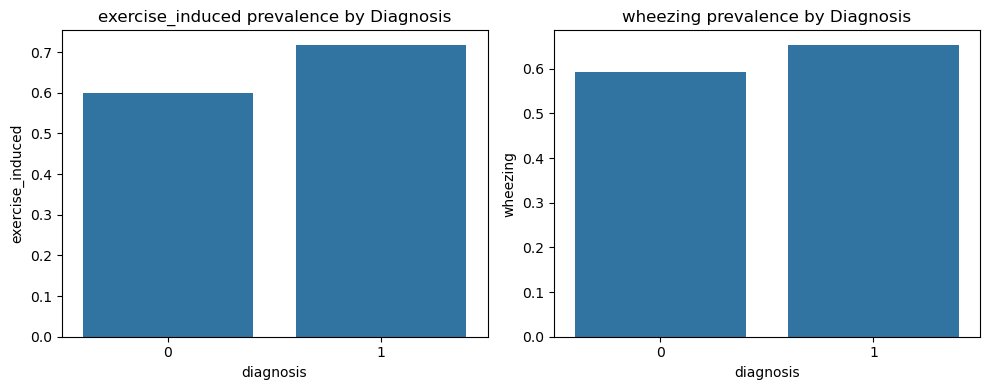

In [22]:
binary_top = ["exercise_induced", "wheezing"]

plt.figure(figsize=(10, 4))
for i, col in enumerate(binary_top, 1):
    plt.subplot(1, 2, i)
    sns.barplot(x="diagnosis", y=col, data=asthma_data, errorbar = None)
    plt.title(f"{col} prevalence by Diagnosis")
plt.tight_layout()
plt.show()

**Age:** The distributions look broadly similar between diagnosed and non-diagnosed groups. No strong age pattern emerges.

**BMI:** Medians and spreads overlap closely; BMI does not seem to differ systematically by diagnosis.

**FEV1 & FVC:** Interestingly, the diagnosed group shows slightly higher median values for both FEV1 and FVC compared to the non-diagnosed group. This is counterintuitive, since asthma is typically associated with reduced lung function. However, the proportion-based measure (FEV1/FVC ratio) tells a different story.

**FEV1/FVC ratio:** The ratio is lower in the diagnosed group despite slightly higher absolute FEV1 and FVC values. This fits clinical understanding: the relative balance of FEV1 to FVC, not their absolute magnitude, is what signals airflow limitation.

Binary Features:

**Exercise-induced symptoms:** ~72% of diagnosed vs ~60% of non-diagnosed patients — this is the clearest distinguishing feature.

**Wheezing:** More common in diagnosed patients (~65% vs ~59%), though the difference is less pronounced.

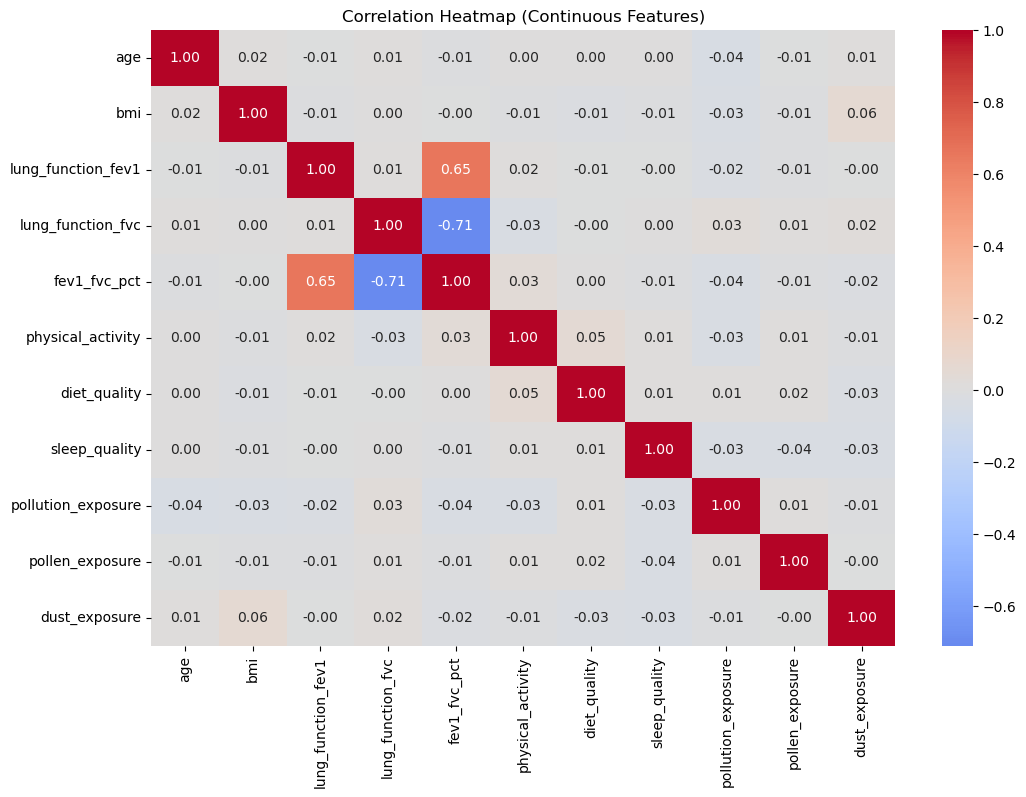

In [23]:
plt.figure(figsize=(12, 8))
cont_cols = asthma_data[["age", "bmi", "lung_function_fev1", "lung_function_fvc", "fev1_fvc_pct",
                    "physical_activity", "diet_quality", "sleep_quality",
                    "pollution_exposure", "pollen_exposure", "dust_exposure"]]
cont_corr = cont_cols.corr()

sns.heatmap(cont_corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Heatmap (Continuous Features)")
plt.show()

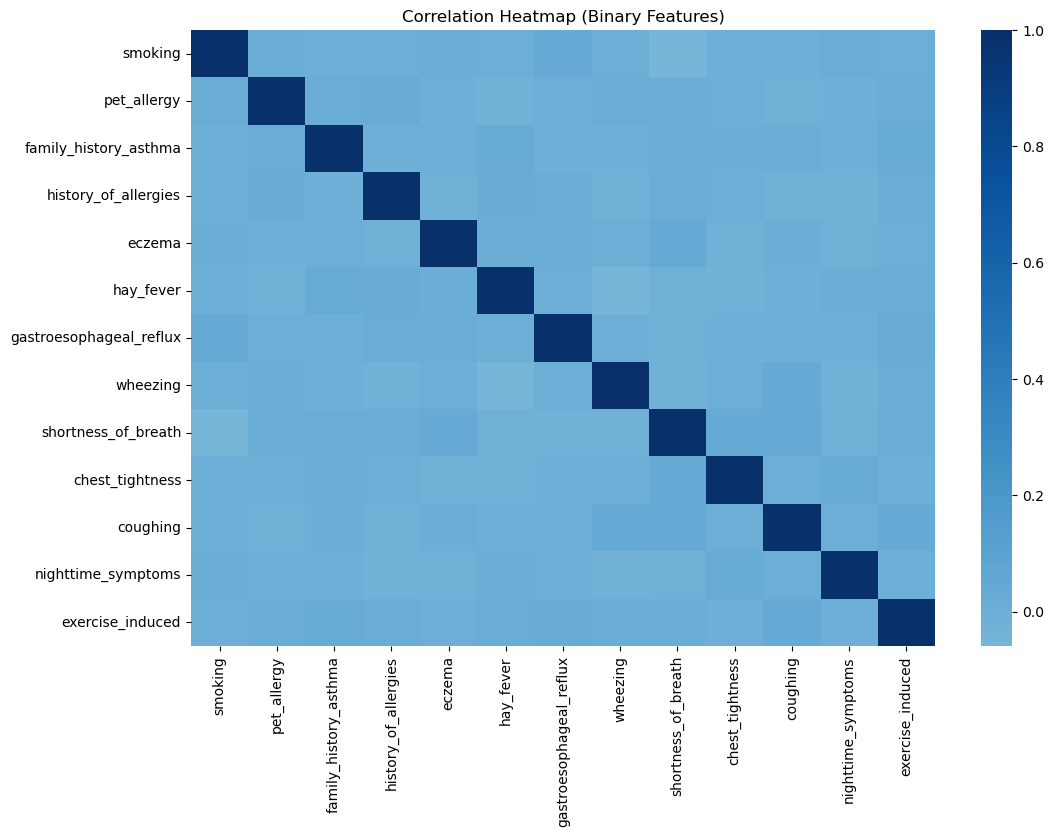

In [24]:
binary_cols = ["smoking", "pet_allergy", "family_history_asthma", "history_of_allergies",
               "eczema", "hay_fever", "gastroesophageal_reflux",
               "wheezing", "shortness_of_breath", "chest_tightness", "coughing",
               "nighttime_symptoms", "exercise_induced"]

plt.figure(figsize=(12, 8))
binary_corr = asthma_data[binary_cols].corr()
sns.heatmap(binary_corr, cmap="Blues", center=0)
plt.title("Correlation Heatmap (Binary Features)")
plt.show()

In [25]:
print("Continuous correlations:\n", cont_corr.round(2))

print("\nBinary correlations:\n", binary_corr.round(2))

Continuous correlations:
                      age   bmi  lung_function_fev1  lung_function_fvc  \
age                 1.00  0.02               -0.01               0.01   
bmi                 0.02  1.00               -0.01               0.00   
lung_function_fev1 -0.01 -0.01                1.00               0.01   
lung_function_fvc   0.01  0.00                0.01               1.00   
fev1_fvc_pct       -0.01 -0.00                0.65              -0.71   
physical_activity   0.00 -0.01                0.02              -0.03   
diet_quality        0.00 -0.01               -0.01              -0.00   
sleep_quality       0.00 -0.01               -0.00               0.00   
pollution_exposure -0.04 -0.03               -0.02               0.03   
pollen_exposure    -0.01 -0.01               -0.01               0.01   
dust_exposure       0.01  0.06               -0.00               0.02   

                    fev1_fvc_pct  physical_activity  diet_quality  \
age                        -

From the continious variables, as one might expect FEV1 and  FVC are very strongly correlated (makes sense: both measure lung volume). Keeping both risks redundancy.

Moreover, FEV1/FVC percentage is also strongly correlated with FEV1 and FVC (because it’s derived from them).In practice, it would be best to keep the percentage (clinically meaningful) and drop at least one of the raw lung function measures.

Other continuous features (age, BMI, lifestyle scores, exposures) showed low correlations, so there are no multicollinearity issue.

For the binary variable we see that symptoms cluster: wheezing, coughing, chest tightness, shortness of breath, nighttime symptoms, exercise induced all show moderate positive correlations. This can be easily explained by the fact that patients often report multiple symptoms together. 

These are clinically plausible and not redundant enough to drop outright — but they may cause multicollinearity in logistic regression. Regularization (L1/L2) can handle that.

We see there is a second cluster that forms. We can call it the allergy/atopy cluster: eczema, hay fever, history of allergies, family history of asthma, pet allergy. These exhibit some mild-to-moderate correlations, consistent with allergic phenotype. These don't appear extreme, so I will keep it for now. 

In [26]:
# Drop redundant lung function feature
asthma_data = asthma_data.drop(columns=["lung_function_fvc"])

In [27]:
out_path = PROC_DIR / "asthma_clean.parquet"
asthma_data.to_parquet(out_path, index=False)
print("Saved to:", out_path)

Saved to: C:\Data Science\07.Data-Science-Project-Architecture-Lab\data\processed\asthma_clean.parquet
